In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Import Libraries

import os
import pandas as pd
import numpy as np
import cv2
import json
import matplotlib.pyplot as plt
import random
import seaborn as sns
import pickle
from keras.models import Sequential, load_model
from keras import optimizers
from keras import backend as K
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from google.colab import files

img_size = 124

directory = "./gdrive/MyDrive/Soft Computing Assignment/Data/Medical Mask/annotations"
image_directory = "./gdrive/MyDrive/Soft Computing Assignment/Data/Medical Mask/images"

# OpenCV model for face detection
cvNet = cv2.dnn.readNetFromCaffe('./gdrive/MyDrive/Soft Computing Assignment/Cafe Face Detector/architecture.txt','./gdrive/MyDrive/Soft Computing Assignment/Cafe Face Detector/weights.caffemodel')

In [ ]:
# Function to read annotation files

def getJSON(filePathandName):
    with open(filePathandName,'r') as f:
        return json.load(f)

# **Data Exploratory**

In [ ]:
df = pd.read_csv("./gdrive/MyDrive/Soft Computing Assignment/train.csv")
df_test = pd.read_csv("./gdrive/MyDrive/Soft Computing Assignment/submission.csv")

df.head()

,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


In [ ]:
### Null Values, Unique Values

unique_values = df["name"].unique()
print("Total Records: ", len(df))
print("Unique Images: ",len(unique_values))

null_values = df.isnull().sum(axis = 0)
print("\n> Null Values in each column <")
print(null_values)

Total Records:  15412
Unique Images:  4326

> Null Values in each column <
name         0
x1           0
x2           0
y1           0
y2           0
classname    0
dtype: int64


In [ ]:
### Total Classes

classes = df["classname"].unique()
print("Total Classes: ",len(classes))
print("\n> Classes <\n",classes)

Total Classes:  20

> Classes <
 ['face_with_mask' 'mask_colorful' 'face_no_mask'
 'face_with_mask_incorrect' 'mask_surgical' 'face_other_covering'
 'scarf_bandana' 'eyeglasses' 'helmet' 'face_shield' 'sunglasses' 'hood'
 'hat' 'goggles' 'hair_net' 'hijab_niqab' 'other' 'gas_mask'
 'balaclava_ski_mask' 'turban']


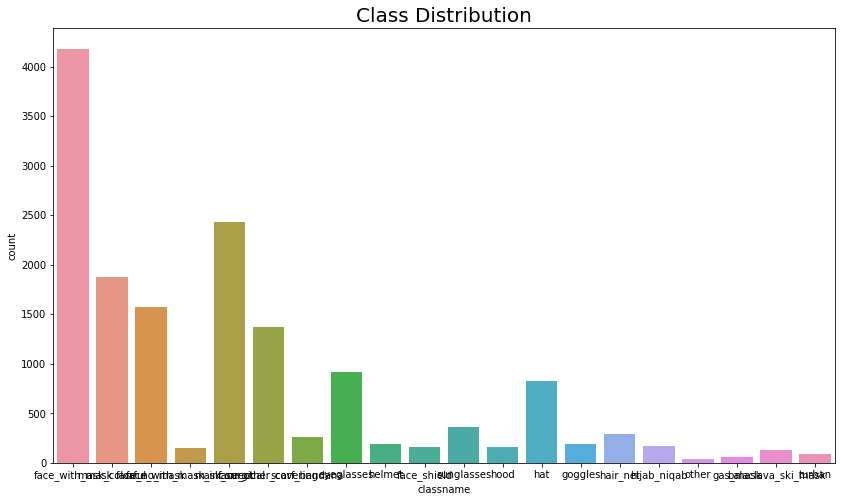

In [ ]:
### Visualizing Class Distribution

plt.figure(figsize=(14,8))
plt.title('Class Distribution', fontsize= 20)
sns.countplot(x = "classname", data = df)

# **Data Preprocessing**

In [ ]:
# Specify the classes to be used

classes = ['face_with_mask', 'face_no_mask', 'face_with_mask_incorrect', 'face_other_covering']
labels = {classes[i] : i for i in range(len(classes))}
assign = {i : classes[i] for i in range(len(classes))}

print("labels: \n", labels)
print("\nassign: \n", assign)

labels: 
 {'face_with_mask': 0, 'face_no_mask': 1, 'face_with_mask_incorrect': 2, 'face_other_covering': 3}

assign: 
 {0: 'face_with_mask', 1: 'face_no_mask', 2: 'face_with_mask_incorrect', 3: 'face_other_covering'}


In [ ]:
# Loop through the training data and append required data to data list for further process.

data = []
for i in df["name"].unique():
    f = i+".json"
    for j in getJSON(os.path.join(directory,f)).get("Annotations"):
        for class_name in classes:
          if class_name == j["classname"]:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory,i),1)
            img = img[y:h,x:w]
            try:
              img = cv2.resize(img,(img_size,img_size))
            except:
              if not os.path.isfile(os.path.join(image_directory,i)):
                print(f"Could not open: {i}")
              break
            data.append([img,labels[class_name]])
            break
random.shuffle(data)

In [ ]:
# As loading data from the step above took a lots of time, it is more convenient for us to save the loaded data into a file.
# Pickling
DATA_PATH = "./gdrive/MyDrive/Soft Computing Assignment/data_4_classes.pkl"

with open(DATA_PATH, "wb") as f: 
  pickle.dump(data, f)

In [ ]:
# Load the saved data from pickle file.
# Unpickling 
DATA_PATH = "./gdrive/MyDrive/Soft Computing Assignment/data_4_classes.pkl"
open_file = open(DATA_PATH, "rb")
data = pickle.load(open_file)
open_file.close()

In [ ]:
print(f"the length of data to be used: {len(data)}\n")

# Split data into X(intput) and Y(output)
X = []
Y = []
for features,label in data:
    X.append(features)
    Y.append(label)

print(f"Shape of individual input(X): {X[0].shape}\n")
input_shape = X[0].shape

X = np.array(X)/255.0
X = X.reshape(-1,124,124,3)
Y = np.array(Y)
output_shape = len(np.unique(Y))

print("Before one-hot encoding")
print(f"Unique values in output(Y): {np.unique(Y)}")
print(f"Shape of output(Y): {Y.shape}")
print(f"Example Y[0]: {Y[0]}\n")


# Perform one-hot encoding on the labels
lb = LabelBinarizer()
Y = lb.fit_transform(Y)

print("After one-hot encoding")
print(f"Unique values in output(Y): {np.unique(Y)}")
print(f"Shape of output(Y): {Y.shape}")
print(f"Example Y[0]: {Y[0]}\n")

the length of data to be used: 7270

Shape of individual input(X): (124, 124, 3)

Before one-hot encoding
Unique values in output(Y): [0 1 2 3]
Shape of output(Y): (7270,)
Example Y[0]: 0

After one-hot encoding
Unique values in output(Y): [0 1]
Shape of output(Y): (7270, 4)
Example Y[0]: [1 0 0 0]



# **Create Model for training**

In [ ]:
# Create CNN with 3 convolutional layer from scratch
def my_model(input_shape, output_shape)
  model = Sequential()

  model.add(Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=input_shape))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))
 
  model.add(Flatten())
  model.add(Dropout(0.5))
  model.add(Dense(50, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(output_shape, activation='softmax'))

  model.compile(loss='categorical_crossentropy', 
                optimizer="adam", 
                metrics=['accuracy'])

  return model

In [ ]:
# Create CNN with 1 convolutional layer from scratch
def my_cnn1(input_shape, output_shape):
  cnn1 = Sequential()

  cnn1.add(Conv2D(32, kernel_size=(3, 3), padding = "same", activation='relu', input_shape=input_shape))
  cnn1.add(MaxPooling2D(pool_size=(2, 2)))
  cnn1.add(Dropout(0.2))

  cnn1.add(Flatten())

  cnn1.add(Dense(128, activation='relu'))
  cnn1.add(Dense(output_shape, activation='softmax'))

  cnn1.compile(loss="categorical_crossentropy",
               optimizer="adam",
               metrics=['accuracy'])
  
  return cnn1

In [ ]:
# Create another CNN with 3 convolutional layer from scratch
def my_cnn3(input_shape, output_shape):
  cnn3 = Sequential()

  cnn3.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
  cnn3.add(MaxPooling2D((2, 2)))
  cnn3.add(Dropout(0.25))

  cnn3.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
  cnn3.add(MaxPooling2D(pool_size=(2, 2)))
  cnn3.add(Dropout(0.25))

  cnn3.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
  cnn3.add(Dropout(0.4))

  cnn3.add(Flatten())

  cnn3.add(Dense(128, activation='relu'))
  cnn3.add(Dropout(0.3))
  cnn3.add(Dense(output_shape, activation='softmax'))

  cnn3.compile(loss="categorical_crossentropy",
               optimizer="adam",
               metrics=['accuracy'])
  
  return cnn3

In [ ]:
# Create CNN with 4 convolutional layer from scratch
def my_cnn4(input_shape, output_shape):
  cnn4 = Sequential()
  cnn4.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
  cnn4.add(BatchNormalization())

  cnn4.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
  cnn4.add(BatchNormalization())
  cnn4.add(MaxPooling2D(pool_size=(2, 2)))
  cnn4.add(Dropout(0.25))

  cnn4.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
  cnn4.add(BatchNormalization())
  cnn4.add(Dropout(0.25))

  cnn4.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
  cnn4.add(BatchNormalization())
  cnn4.add(MaxPooling2D(pool_size=(2, 2)))
  cnn4.add(Dropout(0.25))

  cnn4.add(Flatten())

  cnn4.add(Dense(512, activation='relu'))
  cnn4.add(BatchNormalization())
  cnn4.add(Dropout(0.5))

  cnn4.add(Dense(128, activation='relu'))
  cnn4.add(BatchNormalization())
  cnn4.add(Dropout(0.5))

  cnn4.add(Dense(output_shape, activation='softmax'))

  cnn4.compile(loss="categorical_crossentropy",
               optimizer="adam",
               metrics=['accuracy'])
  
  return cnn4

In [ ]:
# To create model from scratch
model = my_cnn3(input_shape, output_shape)

# Transer learning
# Implement existing classification model. Re-use the architecture.
# from tensorflow.keras.applications import MobileNet, MobileNetV2, ResNet50, MobileNetV3Large
# model = MobileNet(input_shape=input_shape,
#                   weights=None,
#                   classes=output_shape
#                   )

# model.compile(loss="categorical_crossentropy",
#                optimizer="adam",
#               metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 122, 122, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 61, 61, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 59, 59, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 29, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 29, 29, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 128)       7

In [ ]:
# If already have a pre-trained model.
model = load_model('my_model.h5')
model.summary()

In [ ]:
checkpoint_path = "training_2/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

from keras.callbacks import ModelCheckpoint

# Create a callback that saves the model's weights
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                              save_weights_only=True,
                              save_best_only=True,  # Only save a model if `val_loss` has improved.
                              monitor="val_loss",
                              verbose=1)

# **Split data into Train and Validating Set and Start Training**

In [ ]:
xtrain,xval,ytrain,yval=train_test_split(X, Y,train_size=0.8,random_state=0)

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,    
        rotation_range=15,    
        width_shift_range=0.1,
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=False)
datagen.fit(xtrain)

In [ ]:
history = model.fit_generator(datagen.flow(xtrain, ytrain, batch_size=32),
                    steps_per_epoch=xtrain.shape[0]//32,
                    epochs=30, # for testing purpose
                    verbose=1,
                    validation_data=(xval, yval),
                    callbacks=[cp_callback])

MODEL_PATH = "./gdrive/MyDrive/Soft Computing Assignment/model_e30_cnn3_t2.h5"
model.save(MODEL_PATH)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
181/181 [==============================] - 131s 636ms/step - loss: 1.3291 - accuracy: 0.5777 - val_loss: 0.8103 - val_accuracy: 0.6926

Epoch 00001: val_loss improved from inf to 0.81031, saving model to training_2/cp.ckpt
Epoch 2/30
181/181 [==============================] - 112s 619ms/step - loss: 0.7436 - accuracy: 0.7104 - val_loss: 0.6598 - val_accuracy: 0.7503

Epoch 00002: val_loss improved from 0.81031 to 0.65981, saving model to training_2/cp.ckpt
Epoch 3/30
181/181 [==============================] - 112s 619ms/step - loss: 0.7027 - accuracy: 0.7210 - val_loss: 0.6667 - val_accuracy: 0.7476

Epoch 00003: val_loss did not improve from 0.65981
Epoch 4/30
181/181 [==============================] - 113s 623ms/step - loss: 0.6679 - accuracy: 0.7542 - val_loss: 0.6256 - val_accuracy: 0.7565

Epoch 00004: val_loss improved from 0.65981 to 0.62561, saving model to training_2/cp.ckpt
Epoch 5/30
181/181 [==============================] - 113s 621ms/step - loss: 0.6647 - accur

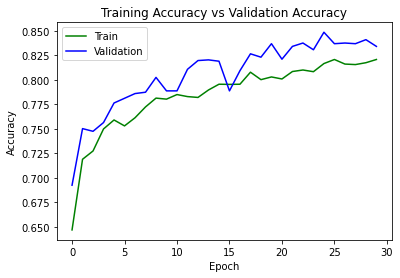

In [ ]:
plt.plot(history.history['accuracy'],'g')
plt.plot(history.history['val_accuracy'],'b')
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

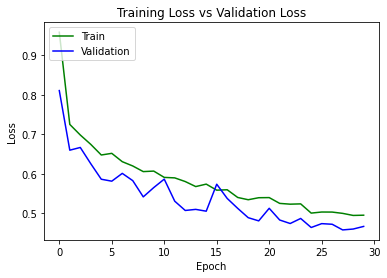

In [ ]:
plt.plot(history.history['loss'],'g')
plt.plot(history.history['val_loss'],'b')
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
print(len(df_test["name"]),len(df_test["name"].unique()))

8142 1698


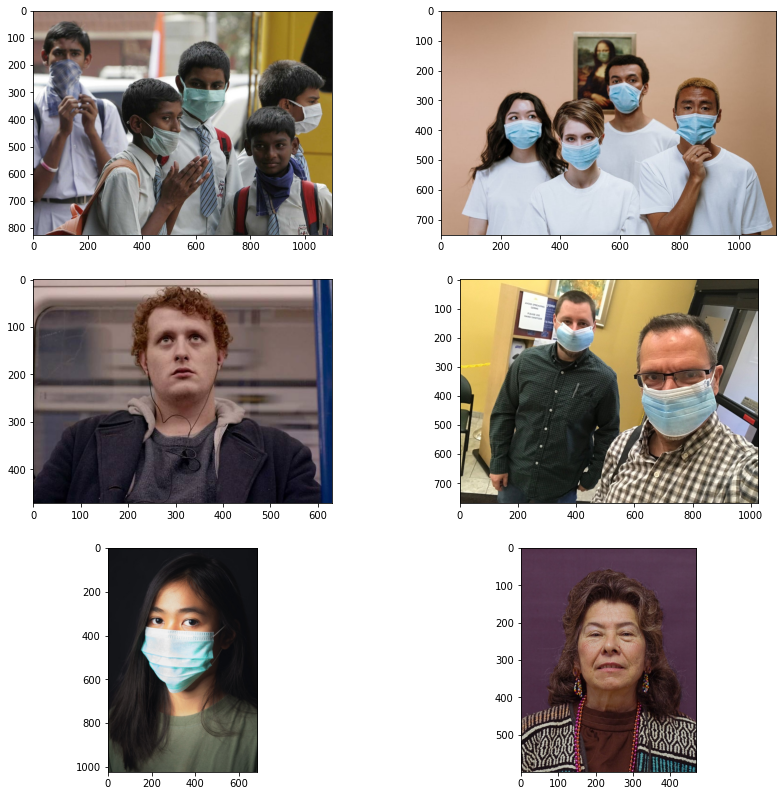

In [ ]:
# Evaluate the model with some test images.
test_images = ['0902.jpg', '0072.jpg', '5613.jpg', '0824.jpg', '0782.jpg', '0895.jpg']
fig = plt.figure(figsize = (14,14))
rows = 3
cols = 2
axes = []
for j,im in enumerate(test_images):
    image =  cv2.imread(os.path.join(image_directory,im),1)
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300,300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    cvNet.setInput(blob)
    detections = cvNet.forward()
    for i in range(0, detections.shape[2]):
        try:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            frame = image[startY:endY, startX:endX]
            confidence = detections[0, 0, i, 2]
            if confidence > 0.2:
              im = cv2.resize(frame,(img_size,img_size))
              im = np.array(im)/255.0
              im = im.reshape(1,124,124,3)
              result = model.predict(im)
              label_Y = np.argmax(result)
              ## Comment these 2 lines to plot the input image for evaluation, uncomment to see the result.
              # cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)           
              # cv2.putText(image,assign[label_Y] , (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (36,255,12), 2)
        
        except:pass
    axes.append(fig.add_subplot(rows, cols, j+1))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

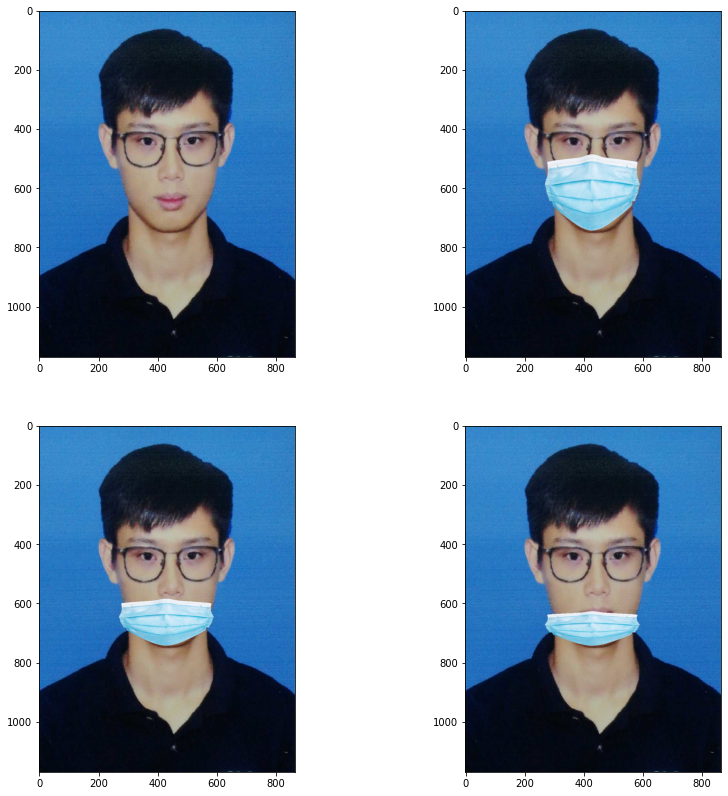

In [ ]:
# Try out with my own images
own_images = ["my.jpg", "fully_covered.png", "nose_not_covered.png", "until_chin.png"]
own_directory = "./gdrive/MyDrive/Soft Computing Assignment/own_images"
fig = plt.figure(figsize = (14,14))
rows = 2
cols = 2
axes = []
for j,im in enumerate(own_images):
    image =  cv2.imread(os.path.join(own_directory,im),1)
    # image =  adjust_gamma(image, gamma=gamma)
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300,300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    cvNet.setInput(blob)
    detections = cvNet.forward()
    for i in range(0, detections.shape[2]):
        try:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            frame = image[startY:endY, startX:endX]
            confidence = detections[0, 0, i, 2]
            if confidence > 0.2:
              im = cv2.resize(frame,(img_size,img_size))
              im = np.array(im)/255.0
              im = im.reshape(1,124,124,3)
              result = model.predict(im)
              label_Y = np.argmax(result)
              ## Comment these 2 lines to plot the input image for evaluation, uncomment to see the result.
              # cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
              # cv2.putText(image,assign[label_Y] , (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (36,255,12), 2)
        
        except:pass
    axes.append(fig.add_subplot(rows, cols, j+1))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()